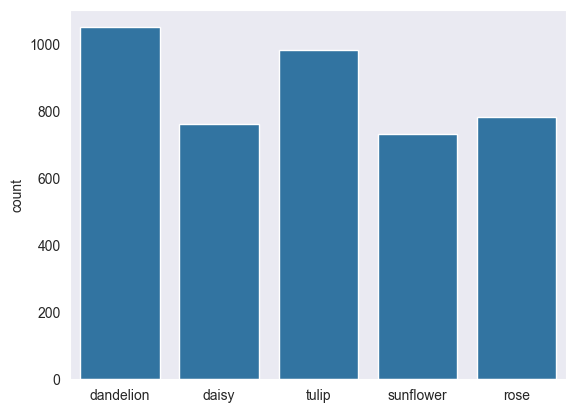

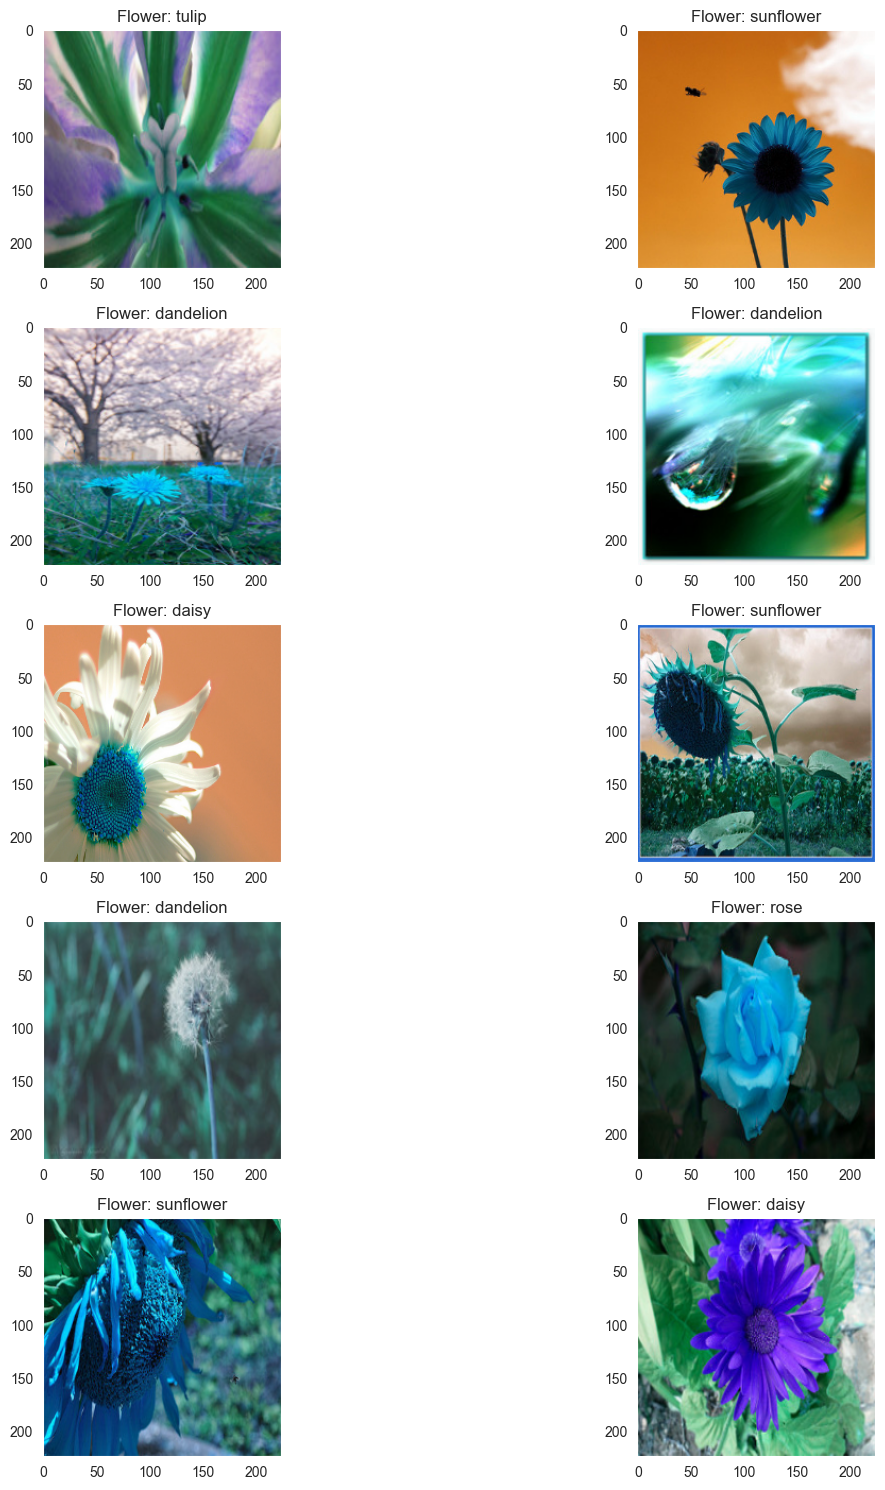

REPLICAS:  1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

Epoch 1/2
41/54 ━━━━━━━━━━━━━━━━━━━━ 1:18 6s/step - accuracy: 0.3258 - loss: 1.7937

KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import pandas as pd
import random

labels = ['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']
img_size = 224

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

data = get_data("input/flowers")

# Plotting the distribution of the data
l = [labels[i[1]] for i in data]
sns.set_style('dark')
sns.countplot(x=l)
plt.show()

# Displaying some sample images
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
for i in range(5):
    for j in range(2):
        l = random.randint(0, len(data) - 1)
        ax[i, j].imshow(data[l][0])
        ax[i, j].set_title('Flower: ' + labels[data[l][1]])
plt.tight_layout()
plt.show()

x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

# Normalize the data
x = np.array(x) / 255.0

# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

del x, y, data

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Load the VGG19 model with local weights
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights="/Users/lotannaokeke/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2, 2), strides=2),
        Flatten(),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_data=(x_test, y_test), callbacks=[learning_rate_reduction])

print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")

epochs = [i for i in range(2)]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Make predictions
predictions_prob = model.predict(x_test)
predictions = np.argmax(predictions_prob, axis=1)

# Inverse transform the one-hot encoded test labels
y_test_inv = label_binarizer.inverse_transform(y_test)

# Print classification report
print(classification_report(y_test_inv, predictions, target_names=labels))

# Plot confusion matrix
cm = confusion_matrix(y_test_inv, predictions)
cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)

# Storing some properly classified and misclassified indexes
prop_class = []
mis_class = []

for i in range(len(y_test_inv)):
    if y_test_inv[i] == predictions[i] and len(prop_class) < 8:
        prop_class.append(i)
    if y_test_inv[i] != predictions[i] and len(mis_class) < 8:
        mis_class.append(i)

# Plot properly classified examples
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title("Predicted Flower: " + labels[predictions[prop_class[count]]] + "\n" + "Actual Flower: " + labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count += 1

# Plot misclassified examples
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]])
        ax[i, j].set_title("Predicted Flower: " + labels[predictions[mis_class[count]]] + "\n" + "Actual Flower: " + labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count += 1


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import pandas as pd
import random

labels = ['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']
img_size = 224

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

data = get_data("input/flowers")

# Plotting the distribution of the data
l = [labels[i[1]] for i in data]
sns.set_style('dark')
sns.countplot(x=l)
plt.show()

# Displaying some sample images
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
for i in range(5):
    for j in range(2):
        l = random.randint(0, len(data) - 1)
        ax[i, j].imshow(data[l][0])
        ax[i, j].set_title('Flower: ' + labels[data[l][1]])
plt.tight_layout()
plt.show()

x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

# Normalize the data
x = np.array(x) / 255.0

# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

del x, y, data

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen.fit(x_train)

# Create the enhanced CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=5, validation_data=(x_test, y_test), callbacks=[learning_rate_reduction, early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy * 100, "%")

# Plotting training & validation accuracy and loss
epochs = [i for i in range(len(history.history['accuracy']))]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Make predictions
predictions_prob = model.predict(x_test)
predictions = np.argmax(predictions_prob, axis=1)

# Inverse transform the one-hot encoded test labels
y_test_inv = label_binarizer.inverse_transform(y_test)

# Print classification report
print(classification_report(y_test_inv, predictions, target_names=labels))

# Plot confusion matrix
cm = confusion_matrix(y_test_inv, predictions)
cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)

# Storing some properly classified and misclassified indexes
prop_class = []
mis_class = []

for i in range(len(y_test_inv)):
    if y_test_inv[i] == predictions[i] and len(prop_class) < 8:
        prop_class.append(i)
    if y_test_inv[i] != predictions[i] and len(mis_class) < 8:
        mis_class.append(i)

# Plot properly classified examples
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title("Predicted Flower: " + labels[predictions[prop_class[count]]] + "\n" + "Actual Flower: " + labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count += 1

# Plot misclassified examples
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[mis_class[count]])
        ax[i, j].set_title("Predicted Flower: " + labels[predictions[mis_class[count]]] + "\n" + "Actual Flower: " + labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count += 1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models

# Downloading and extracting the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = torch.hub._get_torch_home() + '/flower_photos'
torchvision.datasets.utils.download_and_extract_archive(dataset_url, data_dir)

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(12, 12))
imshow(out, title=[class_names[x] for x in classes])

# Define the model architecture
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, criterion, optimizer, num_epochs=15):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

model = train_model(model, criterion, optimizer, num_epochs=15)

# Visualize model training results
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)
plt.show()

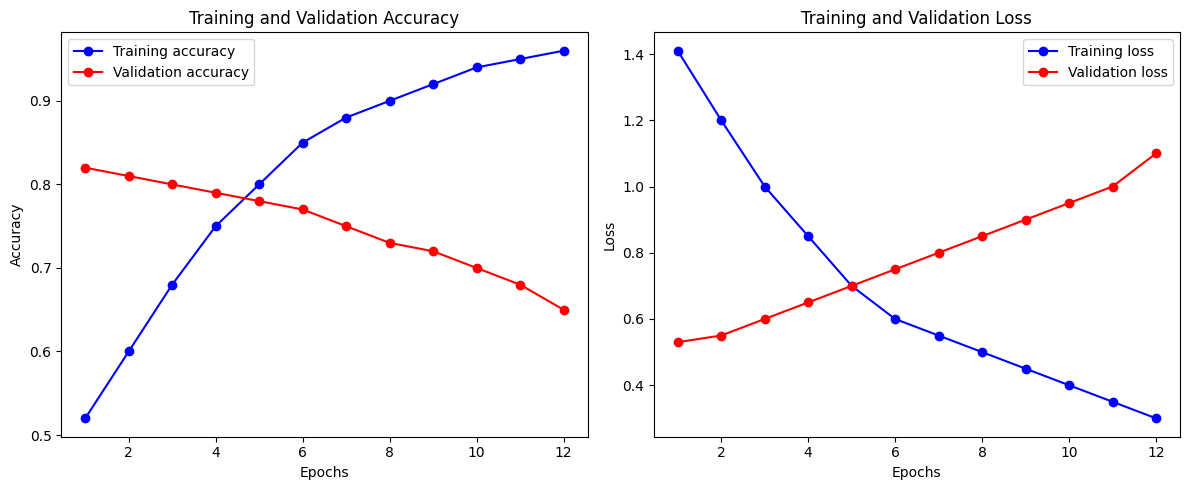

In [3]:
# example of overfitting
import matplotlib.pyplot as plt

# Hypothetical training history data
epochs = range(1, 13)
training_accuracy = [0.52, 0.60, 0.68, 0.75, 0.80, 0.85, 0.88, 0.90, 0.92, 0.94, 0.95, 0.96]
validation_accuracy = [0.82, 0.81, 0.80, 0.79, 0.78, 0.77, 0.75, 0.73, 0.72, 0.70, 0.68, 0.65]
training_loss = [1.41, 1.20, 1.00, 0.85, 0.70, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30]
validation_loss = [0.53, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.10]

# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


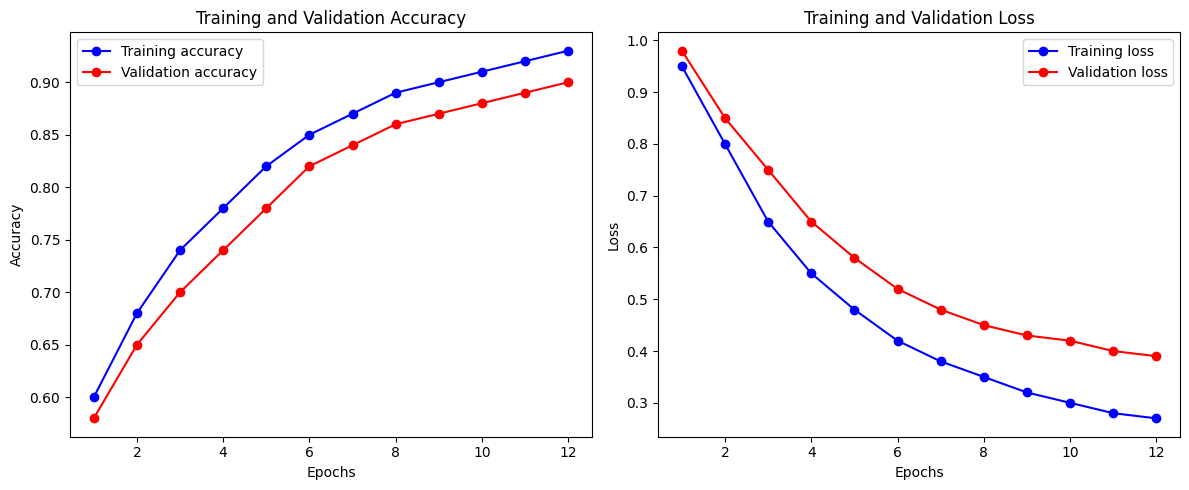

In [2]:
# example of ideal data
import matplotlib.pyplot as plt

epochs = range(1, 13)
training_accuracy = [0.60, 0.68, 0.74, 0.78, 0.82, 0.85, 0.87, 0.89, 0.90, 0.91, 0.92, 0.93]
validation_accuracy = [0.58, 0.65, 0.70, 0.74, 0.78, 0.82, 0.84, 0.86, 0.87, 0.88, 0.89, 0.90]
training_loss = [0.95, 0.80, 0.65, 0.55, 0.48, 0.42, 0.38, 0.35, 0.32, 0.30, 0.28, 0.27]
validation_loss = [0.98, 0.85, 0.75, 0.65, 0.58, 0.52, 0.48, 0.45, 0.43, 0.42, 0.40, 0.39]

# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
